In [8]:
import numpy as np
import struct
from glob import glob
from layer.conv import Conv2D
from layer.relu import ReLU
from layer.linear import Linear
from layer.max_pool import MaxPool
from layer.softmax_loss import Softmax_and_Loss
from layer.bn import BatchNorm2D, BatchNorm1D
from layer.dropout import Dropout
from utils.average import AverageMeter
from random import shuffle

import matplotlib.pyplot as plt

In [2]:
def load_mnist(path, kind='train'):
    """Load MNIST data from `path`"""
    images_path = glob('./%s/%s*3-ubyte' % (path, kind))[0]
    labels_path = glob('./%s/%s*1-ubyte' % (path, kind))[0]

    with open(labels_path, 'rb') as lbpath:
        magic, n = struct.unpack('>II',
                                 lbpath.read(8))
        labels = np.fromfile(lbpath,
                             dtype=np.uint8)

    with open(images_path, 'rb') as imgpath:
        magic, num, rows, cols = struct.unpack('>IIII',
                                               imgpath.read(16))
        images = np.fromfile(imgpath,
                             dtype=np.uint8).reshape(len(labels), 784)

    return images, labels

In [3]:
images, labels = load_mnist('./data/mnist')
test_images, test_labels = load_mnist('./data/mnist', 't10k')
np.random.seed(2018)

In [4]:
batch_size = 128
init_lr = 0.1
step=0
train_loss = AverageMeter()
train_acc = AverageMeter()
val_loss = AverageMeter()
val_acc = AverageMeter()
train_loss_all=[]
val_loss_all=[]
train_acc_all=[]
val_acc_all=[]

In [5]:
# Define network
conv1 = Conv2D(shape=[batch_size, 1, 32, 32], output_channels=6, ksize=5, stride=1, padding=0)    #28*28
bn1 = BatchNorm2D(6)
relu1 = ReLU()
pool1 = MaxPool(2,2,2)  #14*14
conv2 = Conv2D(shape=[batch_size, 6, 14, 14], output_channels=16, ksize=5, stride=1, padding=0)    #10*10
bn2 = BatchNorm2D(16)
relu2 = ReLU()
pool2 = MaxPool(2,2,2)  # 5*5
conv3 = Conv2D(shape=[batch_size, 16, 5, 5], output_channels=120, ksize=5, stride=1, padding=0)    #1*1
bn3 = BatchNorm2D(120)
relu3 = ReLU()
fc1 = Linear(1*1*120, 84)
relu4 = ReLU()
dp = Dropout(0.9)
fc2 = Linear(84, 10)
sf = Softmax_and_Loss()

In [6]:
for epoch in range(1):
    index = [i for i in range(images.shape[0])]
    shuffle(index)
    images = images[index]
    labels = labels[index]
    # train
    for i in range(images.shape[0] // batch_size):
        step+=1
        # learning rate decay
        lr = init_lr*0.9**(step//30)
        # forward
        img = images[i * batch_size:(i + 1) * batch_size].reshape([batch_size, 28, 28, 1]).transpose(0,3,1,2)
        img = np.pad(img, [[0,0],[0,0],[2,2],[2,2]], mode='constant')/255.0
        img = (img-0.1307)/0.3081
        label = labels[i * batch_size:(i + 1) * batch_size]
        out, conv1_cache = conv1.forward(img)
        out, bn1_cache = bn1.forward(out)
        out, relu1_cache = relu1.forward(out)
        out, pool1_cache = pool1.forward(out)

        out, conv2_cache = conv2.forward(out)
        out, bn2_cache = bn2.forward(out)
        out, relu2_cache = relu2.forward(out)
        out, pool2_cache = pool2.forward(out)

        out, conv3_cache = conv3.forward(out)
        out, bn3_cache = bn3.forward(out)
        out, relu3_cache = relu3.forward(out)

        conv_out = out

        out = conv_out.reshape(batch_size, -1)
        out, fc1_cache = fc1.forward(out)
        out, relu4_cache = relu4.forward(out)
        out, dp_cache = dp.forward(out)

        out, fc2_cache = fc2.forward(out)
        loss, dx =  sf.forward_and_backward(out, np.array(label))

        # calculate gradient
        _, _, dx = fc2.gradient(dx, fc2_cache)

        dx = dp.gradient(dx, dp_cache)
        dx = relu4.gradient(dx, relu4_cache)
        _,_,dx = fc1.gradient(dx, fc1_cache)

        dx = dx.reshape(conv_out.shape)

        dx = relu3.gradient(dx, relu3_cache)
        _,_,dx = bn3.gradient(dx, bn3_cache)
        _,_,dx = conv3.gradient(dx, conv3_cache)


        dx = pool2.gradient(dx, pool2_cache)
        dx = relu2.gradient(dx, relu2_cache)
        _, _, dx = bn2.gradient(dx, bn2_cache)
        _, _ ,dx = conv2.gradient(dx, conv2_cache)

        dx = pool1.gradient(dx, pool1_cache)
        dx = relu1.gradient(dx, relu1_cache)
        _, _, dx = bn1.gradient(dx, bn1_cache)
        _,_, dx = conv1.gradient(dx, conv1_cache)

        # backward
        conv1.backward(lr)
        bn1.backward(lr)
        conv2.backward(lr)
        bn2.backward(lr)
        conv3.backward(lr)
        bn3.backward(lr)
        fc1.backward(lr)
        fc2.backward(lr)
        
        
        pred = np.argmax(out, axis=1)
        correct = pred.__eq__(label).sum()
        train_acc.update(correct/label.size*100)
        train_loss.update(loss)


        print(epoch,i,lr, train_loss.avg,train_acc.avg)

        if i%10==0:
            for k in range(test_images.shape[0] // batch_size):
                batch_acc = 0
                img = test_images[k * batch_size:(k + 1) * batch_size].reshape([batch_size, 28, 28, 1]).transpose(0, 3, 1, 2)
                img = np.pad(img, [[0, 0], [0, 0], [2, 2], [2, 2]], mode='constant')/255.0
                img = (img-0.1307)/0.3081
                label = test_labels[k * batch_size:(k + 1) * batch_size]

                out, conv1_cache = conv1.forward(img)
                out, bn1_cache = bn1.forward(out, False)
                out, relu1_cache = relu1.forward(out)
                out, pool1_cache = pool1.forward(out)

                out, conv2_cache = conv2.forward(out)
                out, bn2_cache = bn2.forward(out, False)
                out, relu2_cache = relu2.forward(out)
                out, pool2_cache = pool2.forward(out)

                out, conv3_cache = conv3.forward(out)
                out, bn3_cache = bn3.forward(out, False)
                out, relu3_cache = relu3.forward(out)

                conv_out = out

                out = conv_out.reshape(batch_size, -1)
                out, fc1_cache = fc1.forward(out)
                out, relu4_cache = relu4.forward(out)
                out = dp.forward(out, False)

                out, fc2_cache = fc2.forward(out)
                loss, dx =  sf.forward_and_backward(out, np.array(label))
                
                pred = np.argmax(out, axis=1)
                correct = pred.__eq__(label).sum()
                val_acc.update(correct/label.size*100)
                val_loss.update(loss)
            print("val loss:", val_loss.avg, "val acc:", val_acc.avg)
            
            train_acc_all.append(train_acc.avg)
            train_loss_all.append(train_loss.avg)
            val_acc_all.append(val_acc.avg)
            val_loss_all.append(val_loss.avg)
            
            val_loss.reset()
            val_acc.reset()
            train_acc.reset()
            train_loss.reset()

0 0 0.1 2.52645081199735 12.5
val loss: 2.200469948664174 val acc: 19.110576923076923
0 1 0.1 2.202504631225846 20.3125
0 2 0.1 2.0671934659366444 26.5625
0 3 0.1 1.8858395453735748 36.197916666666664
0 4 0.1 1.7233083283141282 44.3359375
0 5 0.1 1.5824771597656961 49.53125
0 6 0.1 1.4749512630684725 53.125
0 7 0.1 1.3835657530636225 56.138392857142854
0 8 0.1 1.29838568566398 59.1796875
0 9 0.1 1.216273663931536 62.06597222222222
0 10 0.1 1.156227533175099 63.75
val loss: 1.8716592991359828 val acc: 65.64503205128206
0 11 0.1 0.3579445179334239 89.0625
0 12 0.1 0.43947262398912246 87.109375
0 13 0.1 0.4632236889357073 86.19791666666667
0 14 0.1 0.457557833735648 86.328125
0 15 0.1 0.42918186762330424 87.1875
0 16 0.1 0.427185731081116 87.36979166666667
0 17 0.1 0.40642938059205486 87.83482142857143
0 18 0.1 0.4231913469398237 87.3046875
0 19 0.1 0.40311505912898504 87.67361111111111
0 20 0.1 0.40233763903262976 87.65625
val loss: 0.5793050683719027 val acc: 85.09615384615384
0 21 0.1 

0 151 0.05904900000000001 0.1287567815718265 96.09375
0 152 0.05904900000000001 0.1349149465774392 96.484375
0 153 0.05904900000000001 0.13019128286595802 96.35416666666667
0 154 0.05904900000000001 0.1293979053871196 96.2890625
0 155 0.05904900000000001 0.13832189646212764 95.9375
0 156 0.05904900000000001 0.12610229492589295 96.35416666666667
0 157 0.05904900000000001 0.12601915029789976 96.20535714285714
0 158 0.05904900000000001 0.12506246979630334 96.19140625
0 159 0.05904900000000001 0.11897942515569654 96.35416666666667
0 160 0.05904900000000001 0.11073198433489177 96.640625
val loss: 0.10172272924199591 val acc: 96.65464743589743
0 161 0.05904900000000001 0.1856195828435458 95.3125
0 162 0.05904900000000001 0.19137493202075637 94.921875
0 163 0.05904900000000001 0.17681191799951712 94.79166666666667
0 164 0.05904900000000001 0.16186446864430104 95.3125
0 165 0.05904900000000001 0.1491529187500094 95.78125
0 166 0.05904900000000001 0.13783950244955404 96.09375
0 167 0.0590490000

val loss: 0.06571109059740275 val acc: 97.79647435897436
0 281 0.03874204890000001 0.06802132941200001 97.65625
0 282 0.03874204890000001 0.09018440013114146 96.875
0 283 0.03874204890000001 0.09885536337452006 97.13541666666667
0 284 0.03874204890000001 0.0890672037387505 97.4609375
0 285 0.03874204890000001 0.0855767530604371 97.65625
0 286 0.03874204890000001 0.08669295367965917 97.78645833333333
0 287 0.03874204890000001 0.09388716297177806 97.32142857142857
0 288 0.03874204890000001 0.08905625467492961 97.4609375
0 289 0.03874204890000001 0.087672302073593 97.48263888888889
0 290 0.03874204890000001 0.08505480568195553 97.421875
val loss: 0.06525854946709397 val acc: 97.81650641025641
0 291 0.03874204890000001 0.048219583445327424 98.4375
0 292 0.03874204890000001 0.06577651775395679 98.046875
0 293 0.03874204890000001 0.08124652661377142 97.13541666666667
0 294 0.03874204890000001 0.09327991465207441 96.6796875
0 295 0.03874204890000001 0.10654584650142869 96.5625
0 296 0.0387420

0 409 0.02541865828329001 0.0793520539234907 97.65625
0 410 0.02541865828329001 0.08253053254905698 97.65625
val loss: 0.053368007092551815 val acc: 98.3173076923077
0 411 0.02541865828329001 0.08002472982485018 97.65625
0 412 0.02541865828329001 0.0658838489652323 97.65625
0 413 0.02541865828329001 0.06241997901941009 97.65625
0 414 0.02541865828329001 0.060698101778480396 97.8515625
0 415 0.02541865828329001 0.05953482567130599 97.96875
0 416 0.02541865828329001 0.06899008081667309 97.52604166666667
0 417 0.02541865828329001 0.07473061146588092 97.43303571428571
0 418 0.02541865828329001 0.07830195560197056 97.4609375
0 419 0.02287679245496101 0.07624357193910974 97.65625
0 420 0.02287679245496101 0.07275338425383891 97.890625
val loss: 0.0534350798104912 val acc: 98.3573717948718
0 421 0.02287679245496101 0.12846683416889484 96.09375
0 422 0.02287679245496101 0.10159769884664085 96.484375
0 423 0.02287679245496101 0.0952733368119144 97.13541666666667
0 424 0.02287679245496101 0.1028

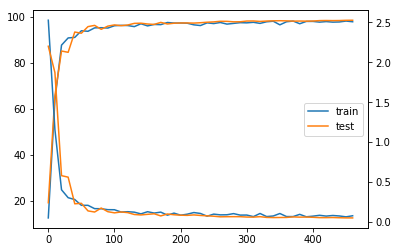

In [21]:
fig=plt.figure()
ax = fig.add_subplot(111)
ax.plot(np.arange(len(train_acc_all))*10,train_acc_all, label="train")
ax.plot(np.arange(len(val_acc_all))*10,val_acc_all, label="test")
ax2 = ax.twinx()
ax2.plot(np.arange(len(train_loss_all))*10,train_loss_all, label="train")
ax2.plot(np.arange(len(val_loss_all))*10,val_loss_all, label="test")
ax.legend(loc='center right')
plt.show()